In [1]:
import geopandas as gpd
import os
from pprint import pprint
import numpy as np
from matplotlib import pyplot as plt
import rasterio as rio
from shapely.geometry import Polygon
from shapely.geometry import box

# Import helper modules
import json
import mercantile
import requests
import urllib
import pandas as pd

from pl_b2p import *

In [2]:
# # load the shapefile
# rwanda_pts = gpd.read_file('../../rwanda/B2P_Rwanda_bridge_sites_2019_05_08.shp')
# rwanda_pts.head()
# print(rwanda_pts.Stage.unique())

# rwanda_pts_NR = rwanda_pts[~rwanda_pts.Stage.isin(['Rejected', 'Identified'])].reset_index()
# rwanda_pts_NR.shape, rwanda_pts.shape

In [3]:
# rwanda_pts = gpd.read_file('../../rwanda/rwanda_no_pts_1000_minus_lakes.shp')

Get all of 'em

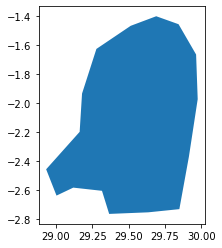

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
rwanda_poly = gpd.read_file(r"D:\projects\bridges_to_prosperity\Fwd__B2P_and_Earth_Lab_areas_of_interest\rwanda_aoi_big.geojson")
rwanda_poly = gpd.read_file(r"D:\projects\bridges_to_prosperity\Fwd__B2P_and_Earth_Lab_areas_of_interest\morija.geojson")
aoi_poly = gpd.read_file("./uganda_initial_no_AOIs/Ibanda_Kabarole_Kasese District Boundaries.shp")
aoi_poly = gpd.read_file(r"D:\projects\bridges_to_prosperity\Fwd__B2P_and_Earth_Lab_areas_of_interest\rwanda_aoi_big.geojson")
aoi_poly = aoi_poly.to_crs(epsg=4326)
aoi_poly.plot()
plt.show()

aoi_bounds = aoi_poly.unary_union.bounds
aoi_poly.crs

In [5]:
zm = 16 # for the bing images, SINCE WE CAN!
pix_size = 2.387 #zm=16
all_tiles_aoi = list(mercantile.tiles(*aoi_bounds, zooms=[zm]))
center_pts = [box(*list(mercantile.bounds(t))).centroid for t in all_tiles_aoi]

# how far apart are the center_pts?
pts_df_4326 = gpd.GeoDataFrame({'geometry':center_pts}, crs=from_epsg(4326))
pts_df_3857 = pts_df_4326.to_crs({'init': 'epsg:3857'})
# pts_df_4326.plot()

dist = pts_df_3857.geometry[0].distance(pts_df_3857.geometry[1])
print(f'distance between tile centroids at level {zm}: {dist:.3f}m')
print(f'pixel distance between tile centroids at level {zm}: {dist/pix_size:.3f} pixels')
print(f'pixel distance between tile centroids at level {zm}, but using pixel size for 17: {dist/1.196:.3f} pixels')

zm = 17 # for the bing images, SINCE WE CAN!
pix_size = 1.196 #zm=17
all_tiles_aoi = list(mercantile.tiles(*aoi_bounds, zooms=[zm]))
center_pts = [box(*list(mercantile.bounds(t))).centroid for t in all_tiles_aoi]

# how far apart are the center_pts?
pts_df_4326 = gpd.GeoDataFrame({'geometry':center_pts}, crs=from_epsg(4326))
pts_df_3857 = pts_df_4326.to_crs({'init': 'epsg:3857'})
# pts_df_4326.plot()

dist = pts_df_3857.geometry[0].distance(pts_df_3857.geometry[1])
print(f'distance between tile centroids at level {zm}: {dist:.3f}m')
print(f'pixel distance between tile centroids at level {zm}: {dist/pix_size:.3f}pixels')

C:\software\anaconda3\envs\gbdx017\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


distance between tile centroids at level 16: 611.496m
pixel distance between tile centroids at level 16: 256.178 pixels
pixel distance between tile centroids at level 16, but using pixel size for 17: 511.284 pixels


C:\software\anaconda3\envs\gbdx017\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


distance between tile centroids at level 17: 305.748m
pixel distance between tile centroids at level 17: 255.642pixels


In [6]:
from math import degrees, atan, sinh
import gdal

def x_to_lon_edges(x, z):
    tile_count = pow(2, z)
    unit = 360 / tile_count
    lon1 = -180 + x * unit
    lon2 = lon1 + unit
    return(lon1, lon2)

def mercatorToLat(mercatorY):
    return(degrees(atan(sinh(mercatorY))))


def y_to_lat_edges(y, z):
    tile_count = pow(2, z)
    unit = 1 / tile_count
    relative_y1 = y * unit
    relative_y2 = relative_y1 + unit
    lat1 = mercatorToLat(np.pi * (1 - 2 * relative_y1))
    lat2 = mercatorToLat(np.pi * (1 - 2 * relative_y2))
    return(lat1, lat2)

def tile_edges(x, y, z):
    lat1, lat2 = y_to_lat_edges(y, z)
    lon1, lon2 = x_to_lon_edges(x, z)
    return[lon1, lat1, lon2, lat2]

def georeference_raster_tile(x, y, z, path):
    bounds = tile_edges(x, y, z)
    filename, extension = os.path.splitext(path)
    gdal.Translate(filename + '.tif',
                   path,
                   outputSRS='EPSG:4326',
                   outputBounds=bounds)

# run for bing maps

In [7]:
from shapely.affinity import translate
from functools import partial

def add_coord_noise(df, maxdist=10):
    
    # add some spatial noise within specified limit
    x_shift = np.random.randn()*maxdist
    y_shift = np.random.randn()*maxdist
    
    # project the data and reproject back
    df = df.to_crs(epsg=3857)
    mapfunc = partial(translate, xoff=x_shift, yoff=y_shift)
    df['geometry'] = list(map(mapfunc, df['geometry']))
    df = df.to_crs(epsg=4326)
    
    return df

In [8]:
# create geometries for image tiles, should be non-overlapping, but pixel requests will be slightly.
zm = 16 # for the bing images, SINCE WE CAN!
pix_size16 = 2.387 #zm=16
pix_size17 = 1.196 #zm=17
all_tiles_aoi = list(mercantile.tiles(*aoi_bounds, zooms=[zm]))
center_pts = [box(*list(mercantile.bounds(t))).centroid for t in all_tiles_aoi]
tile_polys = [box(*list(mercantile.bounds(t))) for t in all_tiles_aoi]

# how far apart are the center_pts?
pts_df_4326 = gpd.GeoDataFrame({'geometry':center_pts}, crs=from_epsg(4326))
poly_df_4326 = gpd.GeoDataFrame({'geometry':tile_polys}, crs=from_epsg(4326))

# write out one of em
poly_df_4326.to_file('test_aoi_tiles.geojson', driver='GeoJSON')

C:\software\anaconda3\envs\gbdx017\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


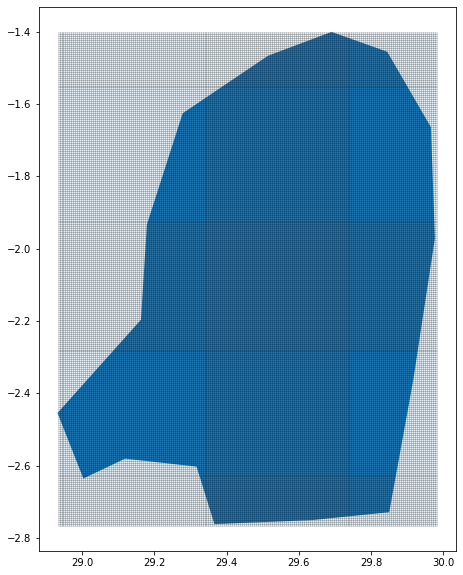

In [9]:
ax = aoi_poly.plot(figsize=(10,10))
poly_df_4326.plot(ax=ax, edgecolor='k', alpha=0.1)

In [10]:
# need to overlay and select ones that intersect
# aoi_poly_df_4326 = gpd.overlay(poly_df_4326, aoi_poly, how='intersection') # i think this clips the edge tiles
aoi_poly_df_4326 = poly_df_4326[poly_df_4326.intersects(aoi_poly.unary_union)]


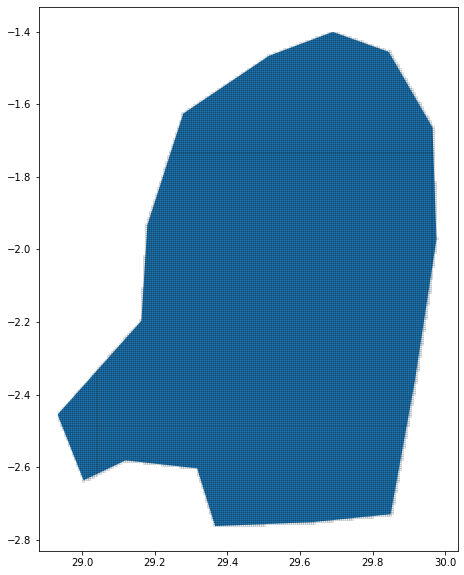

In [11]:
ax = aoi_poly.plot(figsize=(10,10))
aoi_poly_df_4326.plot(ax=ax, edgecolor='k', alpha=0.1)

In [12]:
aoi_poly_df_4326.shape

(32417, 1)

In [42]:
x_ls, y_ls, z_ls, f_ls = [],[],[],[]

# download tile for each point
aoi_name = 'uganda_test_districts'
aoi_folder = f'pngs_{aoi_name}_all_512_zm17'

if not os.path.exists(aoi_folder):
    os.makedirs(aoi_folder)
    
for row in aoi_poly_df_4326.iterrows():
    # specify a point from the geodataframe of accepted stages
    # get a tile coordiante for lon lat  (get from GDF)
    #pt_index=50
    #lon = rwanda_pts_NR.geometry[pt_index].x
    #lat = rwanda_pts_NR.geometry[pt_index].y
    
    try:
        rc = 512

        lon = row[1]['geometry'].centroid.x
        lat = row[1]['geometry'].centroid.y
        zm = 17 # ~1.2m

        t_url = f'https://dev.virtualearth.net/REST/v1/Imagery/Map/Aerial/{lat},{lon}/{zm}?&format=png&mapSize={rc},{rc}&key=Apj6VafMa1ng5CQZKVkTBAGEN8pbGtCJcgB4h2T7VtKVZQrbxqe6orSfUuJ2jXjN' 

        tile_mapping = mercantile.tile(lon, lat, zm)

        z=tile_mapping.z
        x=tile_mapping.x
        y=tile_mapping.y
        im_path = os.path.join(aoi_folder, f'aoi_{aoi_name}_bing_{x}_{y}_{z}.png')
        urllib.request.urlretrieve(t_url, im_path)

        x_ls.append(x)
        y_ls.append(y)
        z_ls.append(z)
        f_ls.append(im_path)
        
    except Exception as e:
        print(e)
        x_ls.append(None)
        y_ls.append(None)
        z_ls.append(None)
        f_ls.append(None)
        


<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time,

<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time,

In [46]:
aoi_poly_df_4326['tile_x'] = x_ls
aoi_poly_df_4326['tile_y'] = y_ls
aoi_poly_df_4326['tile_z'] = z_ls
aoi_poly_df_4326['filename'] = f_ls
aoi_poly_df_4326['filename_base'] = [os.path.basename(f) if f is not None else None for f in f_ls]

C:\software\anaconda3\envs\gbdx017\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\software\anaconda3\envs\gbdx017\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\software\anaconda3\envs\gbdx017\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [47]:
aoi_poly_df_4326.head()

,geometry,tile_x,tile_y,tile_z,filename,filename_base
214,"POLYGON ((29.70154 -0.20325, 29.70154 -0.19775...",76349.0,65608.0,17.0,pngs_uganda_test_districts_all_512_zm17\aoi_ug...,aoi_uganda_test_districts_bing_76349_65608_17.png
215,"POLYGON ((29.70154 -0.20874, 29.70154 -0.20325...",76349.0,65610.0,17.0,pngs_uganda_test_districts_all_512_zm17\aoi_ug...,aoi_uganda_test_districts_bing_76349_65610_17.png
216,"POLYGON ((29.70154 -0.21423, 29.70154 -0.20874...",76349.0,65612.0,17.0,pngs_uganda_test_districts_all_512_zm17\aoi_ug...,aoi_uganda_test_districts_bing_76349_65612_17.png
441,"POLYGON ((29.70703 -0.18127, 29.70703 -0.17578...",76351.0,65600.0,17.0,pngs_uganda_test_districts_all_512_zm17\aoi_ug...,aoi_uganda_test_districts_bing_76351_65600_17.png
442,"POLYGON ((29.70703 -0.18677, 29.70703 -0.18127...",76351.0,65602.0,17.0,pngs_uganda_test_districts_all_512_zm17\aoi_ug...,aoi_uganda_test_districts_bing_76351_65602_17.png


In [48]:
aoi_poly_df_4326.to_file('uganda_test_tiles.geojson', driver='GeoJSON')

In [18]:
bing_df = pd.DataFrame({'tile_x':x_ls,
                        'tile_y': y_ls,
                       'tile_z': z_ls,
                       'filename': f_ls})

In [19]:
bing_df['filename'].unique().shape

(987,)

Write data frames to csv

In [20]:
bing_df.to_csv('png_bing_256_no.csv')
